# Simulating GLasso with Stock portfolio
- [Sparse inverse covariance estimation](#Sparse-inverse-covariance-estimation)
- [Visualization](#Visualization)

# Collecting data

In [13]:
from __future__ import print_function

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import sys
from datetime import datetime
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import cluster, covariance, manifold

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
symbol_dict = { 
    'sgn': 'SAGS CO',
    'hvn': 'VINA AIRLINE',
    'vjc': 'VIETJET AIR',
    'acv': 'ACV CO',
    'pvs': 'PTSC',
    'pvi': 'PVI CO',
    'pvd': 'PV DRILLING',
    'gas': 'PV-GAS',
    'vcg': 'VINACONFX JSC',
    'dxg': 'GREEN LAND',
    'ctd': 'COTECOIN',
    'ros': 'FLC-FAROS',
    'mch': 'MASAN RETAIL',
    'msn': 'MASAN GROUP',
    'sab': 'SABECO',
    'vnm': 'VINAMILK',
    'ctg': 'CTG BANK',
    'bvh': 'BVH GROUP',
    'bid':'BIDV',
    'vcb':'VIETCOMBANK',
    'nvl':'CTHH No Va ',
    'ree':'REE CO',
    'kdh': 'KHANGDIEN HOMES',
    'vic': 'VINGROUP',
}
symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []
for symbol in symbols:
    url = ('./Data-stock/excel_{}.csv')
    df = pd.read_csv(url.format(symbol))
    if df.shape[0] <= 395: #730 :
        print('Dont have enough data %r' % symbol, file=sys.stderr)
    else:
        df = df[['<Ticker>','<DTYYYYMMDD>','<Open>','<Close>']][0:395]
        print('Fetching quote history for %r' % symbol, file=sys.stderr)
        quotes.append(df)

Fetching quote history for 'acv'
Fetching quote history for 'bid'
Fetching quote history for 'bvh'
Fetching quote history for 'ctd'
Fetching quote history for 'ctg'
Fetching quote history for 'dxg'
Fetching quote history for 'gas'
Fetching quote history for 'hvn'
Fetching quote history for 'kdh'
Fetching quote history for 'mch'
Fetching quote history for 'msn'
Fetching quote history for 'nvl'
Fetching quote history for 'pvd'
Fetching quote history for 'pvi'
Fetching quote history for 'pvs'
Fetching quote history for 'ree'
Fetching quote history for 'ros'
Fetching quote history for 'sab'
Fetching quote history for 'sgn'
Fetching quote history for 'vcb'
Fetching quote history for 'vcg'
Fetching quote history for 'vic'
Fetching quote history for 'vjc'
Fetching quote history for 'vnm'


In [4]:
len(quotes[1])

395

In [5]:
close_prices = np.vstack([q['<Close>'] for q in quotes])
open_prices = np.vstack([q['<Open>'] for q in quotes])

In [6]:
close_prices = np.vstack([q['<Close>'] for q in quotes])
open_prices = np.vstack([q['<Open>'] for q in quotes])

# The daily variations of the quotes are what carry most information
#if close_prices - open_prices <= 0:
#    variation = close_prices - open_prices[1:395]

variation = close_prices - open_prices

# Sparse inverse covariance estimation

Using the GraphicalLasso estimator to learn a covariance and sparse precision from a small number of samples.

To estimate a probabilistic model (e.g. a Gaussian model), estimating the precision matrix, that is the inverse covariance matrix, is as important as estimating the covariance matrix. Indeed a Gaussian model is parametrized by the precision matrix.

To be in favorable recovery conditions, we sample the data from a model with a sparse inverse covariance matrix. In addition, we ensure that the data is not too much correlated (limiting the largest coefficient of the precision matrix) and that there a no small coefficients in the precision matrix that cannot be recovered. In addition, with a small number of observations, it is easier to recover a correlation matrix rather than a covariance, thus we scale the time series.

Here, the number of samples is slightly larger than the number of dimensions, thus the empirical covariance is still invertible. However, as the observations are strongly correlated, the empirical covariance matrix is ill-conditioned and as a result its inverse --the empirical precision matrix-- is very far from the ground truth.

If we use l2 shrinkage, as with the Ledoit-Wolf estimator, as the number of samples is small, we need to shrink a lot. As a result, the Ledoit-Wolf precision is fairly close to the ground truth precision, that is not far from being diagonal, but the off-diagonal structure is lost.

The l1-penalized estimator can recover part of this off-diagonal structure. It learns a sparse precision. It is not able to recover the exact sparsity pattern: it detects too many non-zero coefficients. However, the highest non-zero coefficients of the l1 estimated correspond to the non-zero coefficients in the ground truth. Finally, the coefficients of the l1 precision estimate are biased toward zero: because of the penalty, they are all smaller than the corresponding ground truth value, as can be seen on the figure.

Note that, the color range of the precision matrices is tweaked to improve readability of the figure. The full range of values of the empirical precision is not displayed.

The alpha parameter of the GraphicalLasso setting the sparsity of the model is set by internal cross-validation in the GraphicalLassoCV. As can be seen on figure namely "Model selection", the grid to compute the cross-validation score is iteratively refined in the neighborhood of the maximum.


In [7]:
# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)


/home/annguyen/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


GraphicalLassoCV(alphas=4, assume_centered=False, cv=5, enet_tol=0.0001,
         max_iter=100, mode='cd', n_jobs=None, n_refinements=4, tol=0.0001,
         verbose=False)

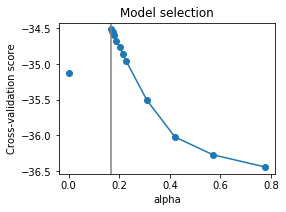

In [8]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(edge_model.cv_alphas_, np.mean(edge_model.grid_scores_, axis=1), 'o-')
plt.axvline(edge_model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()

In [14]:
# #############################################################################
# Estimate the covariance
emp_cov = np.dot(X.T, X) / len(X.T[0])

cov_ = edge_model.covariance_
prec_ = edge_model.precision_

lw_cov_, _ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

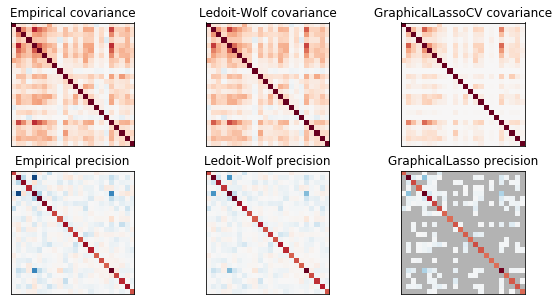

In [34]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical', emp_cov), ('Ledoit-Wolf', lw_cov_),
        ('GraphicalLassoCV', cov_)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 3, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)
    
# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)), ('Ledoit-Wolf', lw_prec_),
         ('GraphicalLasso', prec_)]
vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 3, i + 4)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# Visualization
Visualizing the stock market structure

This example employs several unsupervised learning techniques to extract the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes that are linked tend to cofluctuate during a day.
Learning a graph structure

We use sparse inverse covariance estimation to find which quotes are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connection. For each symbol, the symbols that it is connected too are those useful to explain its fluctuations.

## Embedding in 2D space
    For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use manifold techniques to retrieve 2D embedding.
<br>
The output of the 3 models are combined in a 2D graph where nodes represents the stocks and edges the:
    - cluster labels are used to define the color of the nodes
    - the sparse covariance model is used to display the strength of the edges
    - the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenge is to position the labels minimizing overlap. For this we use an heuristic based on the direction of the nearest neighbor along each axis.

Cluster 1: BIDV, BVH GROUP, COTECOIN, CTG BANK, GREEN LAND, PV-GAS, KHANGDIEN HOMES, PV DRILLING, REE CO, VIETCOMBANK, VINAMILK
Cluster 2: ACV CO, VINA AIRLINE, PTSC, VINACONFX JSC, VIETJET AIR
Cluster 3: MASAN RETAIL
Cluster 4: MASAN GROUP, CTHH No Va , SABECO, VINGROUP
Cluster 5: PVI CO
Cluster 6: FLC-FAROS
Cluster 7: SAGS CO
Cluster 1: BIDV, BVH GROUP, COTECOIN, CTG BANK, GREEN LAND, PV-GAS, KHANGDIEN HOMES, PV DRILLING, REE CO, VIETCOMBANK, VINAMILK
Cluster 2: ACV CO, VINA AIRLINE, PTSC, VINACONFX JSC, VIETJET AIR
Cluster 3: MASAN RETAIL
Cluster 4: MASAN GROUP, CTHH No Va , SABECO, VINGROUP
Cluster 5: PVI CO
Cluster 6: FLC-FAROS
Cluster 7: SAGS CO


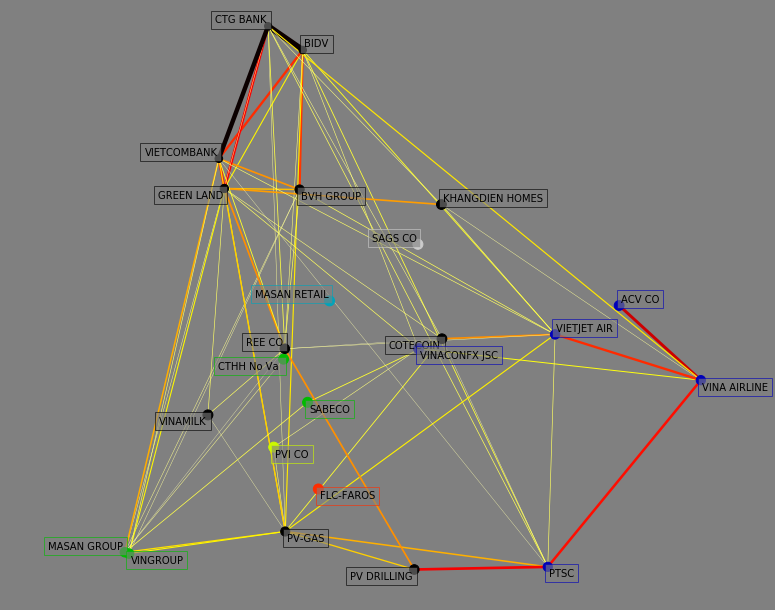

In [11]:
# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T
# #############################################################################
# Visualization
plt.figure(1, facecolor='gray', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='gray',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))
plt.show()